In [1]:
#import libraries and functions
import numpy as np
from arqtic.program import Program, random_bitstring
from arqtic.hamiltonians import Ising_Hamiltonian
from arqtic.arqtic_for_ibm import run_ibm
import arqtic.QITE as qite
import qiskit as qk
from qiskit import Aer, IBMQ, execute
import matplotlib.pyplot as plt

In [2]:
#interfacing with IBM
########################################
#The following only needs to be run if this you very first time running this pynb, comment out all subsequent times
#qk.IBMQ.save_account('API_token_here')
#qk.IBMQ.load_account()
########################################

#set up simulator
simulator = Aer.get_backend('qasm_simulator')
#set optimization level for transpiler
opt_level = 3

In [3]:
#define post-processing functions
#get amouot of work from QC results
def get_work(results, shots):
    work = 0
    for result in results:
        state_vec = result[0]
        count = result[1]
        work_comp = 0
        for i in range(len(state_vec)):
            if (state_vec[i] == 0):
                work_comp += 1
            else:
                work_comp += -1
        work_comp *= count
        work += work_comp
    work = work/shots
    return work

In [13]:
#define system variables
N = 1 #number of qubits
Jz = 0.1 #ising interaction strength !!! Not used for 1-qubit
mu_x = 0.3 #transverse magnetic field strength
param_free_ham = Ising_Hamiltonian(N, Jz, [mu_x, 0, 0]) #parameter-free Hamiltonian
ising_ham0 = Ising_Hamiltonian(N, Jz, [mu_x, 0, 0]) #Hamiltonian at beginning of parameter sweep

#define simulation variables
tau = 10 #total trajectory time to evolve lambda from 0 to 1
dtau = 1.0 #time-step for trajectory
num_steps = int(tau/dtau)
T = 100 #total number of trajectories
dt =  dtau #timestep for Trotter approximation: setting equal to dtau means one trotter-step per time-step in evolution
lambda_protocol = np.linspace(1.0, 0,num_steps)
#print(lambda_protocol)
dldt = (lambda_protocol[1]-lambda_protocol[0])/dtau # d(lambda)/d(tau)
#print(dldt) 
shots = 1000

#define QITE variables
beta = 4.0 #inverse temperature of systems
dbeta = 0.2 #step-size in beta for QITE
domain = 1 #domain of opertators for QITE

In [14]:
#create program to move to x-basis for measurement
prog_xBasis = Program(N)
prog_xBasis.get_x_basis_prog()

#first state should be random
measured_metts_state = random_bitstring(N)
#subsequent entries are derived from running QMETTS on the previously derived
#state and measuring a random observable to get the state for the subsequent run

#need to sum work over each trajectory and then average over works
work = []
#loop over trajectories
for i in range(T):
    #print(i)
    psi0 = qite.get_state_from_string(measured_metts_state)
    prog_TS = Program(N)
    prog_TS.make_ps_prog(measured_metts_state)
    #print(measured_metts_state)
    #print("PS circuit")
    #prog_TS.print_list()
    prog_qite = Program(N)
    #note QITE algorithm should evolve state by beta/2 for temperature beta
    prog_qite.make_QITE_prog(ising_ham0, beta/2.0, dbeta, domain, np.asarray(psi0), 1.0)
    #print("QITE circuit")
    #prog_qite.print_list()
    prog_TS.append_program(prog_qite)
    #print("TS circuit")
    #prog_TS.print_list()
    #make and run qmetts program
    prog_qmetts = Program(N)
    prog_qmetts.append_program(prog_TS)
    #make random measurement operator
    if (i%2 == 0):
        prog_qmetts.append_program(prog_xBasis)
    #print("QMETTS circuit")
    #prog_qmetts.print_list()
    results = run_ibm(simulator, prog_qmetts, opt_level)
    #update measured metts state for next trajectory
    measured_metts_state = results[0][0]
    #make and run JE program
    prog_JE = Program(N)
    prog_JE.append_program(prog_TS)
    #loop over time-steps in trajectory i
    work_i = 0    
    for step in range(num_steps):
        #print(step)
        #make Hamilton Evolution program for given time-step of given trajectory
        prog_hamEvol = Program(N)
        prog_hamEvol.make_hamEvol_prog(step, dtau, dt, lambda_protocol, param_free_ham)
        #complete JE program: combing IPS preparation, QITE, and Hamiltonian evolution
        prog_JE.append_program(prog_hamEvol)
        prog_JE.append_program(prog_xBasis)
        results = run_ibm(simulator, prog_JE, shots, opt_level)
        #print(results)
        #print(get_work(results, shots))
        work_i += dldt*dtau*(-mu_x)*get_work(results, shots)
    work.append(work_i)


#print(work)

#FE = get_free_energy(work)  !!This function not yet implemented

In [15]:
print(work)
print(np.mean(work))

[-0.005399999999999997, -0.007200000000000011, 0.0010000000000000087, -0.010533333333333355, -0.0008666666666666727, -0.0005333333333333162, -0.005800000000000005, 0.0026000000000000016, -0.004466666666666659, -0.0034666666666666665, -0.005466666666666654, -0.0038666666666666736, -0.003399999999999995, -0.0006000000000000033, -0.00553333333333334, -0.003933333333333334, -0.0008666666666666736, -0.007266666666666671, 0.00020000000000000226, -0.003000000000000013, -0.0027333333333333498, -0.005466666666666672, -0.0021333333333333386, -0.004066666666666663, -0.00406666666666667, -0.009666666666666667, -0.004666666666666666, -0.00853333333333332, -0.004800000000000002, -0.002133333333333337, -0.003333333333333326, -0.0036666666666666688, -0.0050000000000000044, -0.006533333333333342, -0.0062666666666666695, -0.0051333333333333266, -0.006666666666666678, -0.005066666666666673, -0.006733333333333327, -0.0056666666666666705, 6.666666666665239e-05, -0.0037333333333333246, -0.001799999999999996

In [16]:
#free energy is 
work_sum = 0
for i in range(T):
    work_sum += np.exp(-beta*work[i])
work_avg = work_sum/T
free_eng = (-1/beta)*np.log(work_avg)
print(free_eng)

-0.004074344115372524


In [ ]:
#save data to file
fname = 'Jz_{}_mu_x_{}_beta_{}_hist.csv'.format(Jz,mu_x, beta)
f = open(fname, 'w')
f.write("N: "+ str(N) + '\n')
f.write("mu_x: "+ str(mu_x) + '\n')
f.write("Jz: "+ str(Jz) + '\n')
f.write("beta: "+ str(beta) + '\n')
f.write("dbeta: "+ str(dbeta) + '\n')
f.write("T: "+ str(T) + '\n')
f.write("tau: "+ str(tau) + '\n')
f.write("dtau: "+ str(dtau) + '\n')

np.savetxt(f, work, delimiter=',')

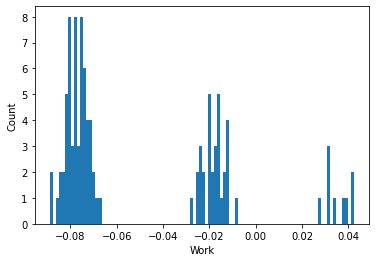

In [6]:
#plot data and save figure
nbins = 100
plt.xlabel('Work')
plt.ylabel('Count')
#data_str = f"N: {N} "+"\n"+f"mu_x: {mu_x}"+"\n"+f"J_z: {Jz}"+"\n"+f"beta: {beta}"+"\n"+f"dbeta: {dbeta}"+"\n"+f"T: {T}"+"\n"+f"tau: {tau}"+"\n"+f"dtau: {dtau}" 
#ax = plt.gca()
#ax.text(0.95, 0.95, data_str,
        #horizontalalignment='right',
        #verticalalignment='top',
        #transform=ax.transAxes)
plt.hist(work, bins = nbins)

#May or may not want to limit x-axis
#plt.xlim(-0.1,0.1)
#fname = 'Jz_{}_mu_x_{}_beta_{}_hist.png'.format(Jz, mu_x, beta)
#plt.savefig(fname)
plt.show()